# Usage on proteins

Although Novae was mainly designed for spatial transcriptomics, it can also be used for spatial proteomics.

The main difference with the [normal tutorial](../main_usage) is that we will not be able to use the pretrained model, so we'll re-train a Novae model from scratch.

In [1]:
import novae

## Loading the data objects

Similarly as in the other tutorials, we need to load one or multiple AnnData object(s). Here, we load the first 2 head&neck slides which have protein information.

See [here](../input_modes) for more details on all four possible input modes for Novae.

In [4]:
adatas = novae.utils.load_dataset(
    top_k=2,
    tissue="head_and_neck",
    custom_filter=lambda df: df["n_proteins"] > 0,
)

[INFO] (novae.utils._data) Found 2 h5ad file(s) matching the filters.


10H064210813H0208914_down.h5ad:   0%|          | 0.00/230M [00:00<?, ?B/s]

10H064210813H0208914_up.h5ad:   0%|          | 0.00/184M [00:00<?, ?B/s]

In [5]:
adatas

[AnnData object with n_obs × n_vars = 140139 × 63
     obs: 'annot_level1', 'ID', 'annot_level0', 'novae_sid'
     uns: 'annot_level0_colors', 'annot_level1_colors', 'spatial_neighbors'
     obsm: 'X_pca', 'X_umap', 'spatial'
     layers: 'counts'
     obsp: 'spatial_connectivities', 'spatial_distances',
 AnnData object with n_obs × n_vars = 112155 × 63
     obs: 'annot_level1', 'ID', 'annot_level0', 'novae_sid'
     uns: 'annot_level0_colors', 'annot_level1_colors', 'spatial_neighbors'
     obsm: 'X_pca', 'X_umap', 'spatial'
     layers: 'counts'
     obsp: 'spatial_connectivities', 'spatial_distances']

## Compute the neighbors graph

Again, this step is similar to the [spatial transcriptomics tutorial](../main_usage).
The only difference is that, in our specific case, the coordinate system is in pixels (not microns), so `radius` is much higher that what we usually set.

> Please adjust `radius` based on your coordinate system, and make sure the plot below looks correct.

In [23]:
novae.utils.spatial_neighbors(adatas, radius=300)

[INFO] (novae.utils._build) Computing graph on 140,139 cells (coord_type=generic, delaunay=True, radius=[0.0, 300.0], n_neighs=None)
[INFO] (novae.utils._build) Computing graph on 112,155 cells (coord_type=generic, delaunay=True, radius=[0.0, 300.0], n_neighs=None)


We can show the graph of connectivities, which is a good quality control. Nodes in red are cells that are connected to very few other cells (`ngh_threshold=2`, by default). In particular:
1. You should have a relatively low amount of "red" cells. If so, decrease the `radius` parameter.
2. Regions that are far apart should not be connected. If so, increase the `radius` parameter.

If the graph is not looking right, check the docs of [`novae.utils.spatial_neighbors`](../../api/utils/#novae.utils.spatial_neighbors) to adapt it.

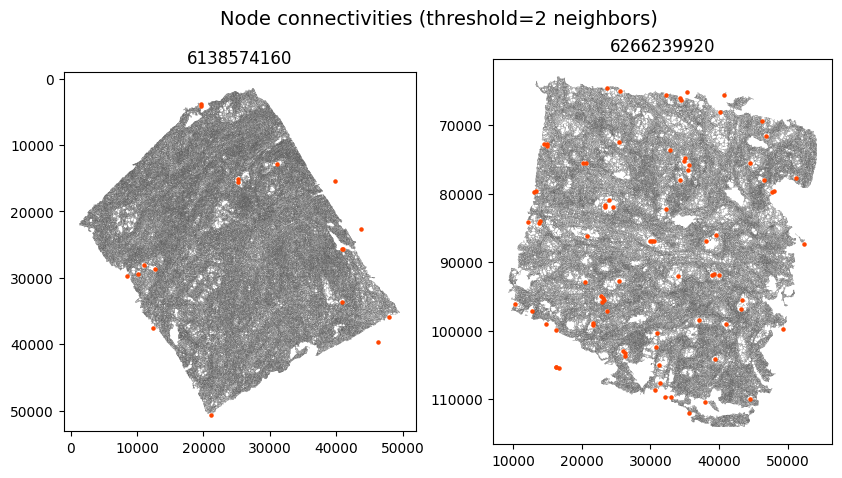

In [24]:
novae.plot.connectivities(adatas)

## Preprocessing

This is the first main difference. For spatial proteomics, we recommend using the preprocessing below.

Check the docs of [`novae.utils.quantile_scaling`](../../api/utils/#novae.utils.quantile_scaling) for more details.

In [8]:
novae.settings.auto_preprocessing = False # prevent Novae from running normalize_total / log1p

novae.utils.quantile_scaling(adatas)

## Training a new model

Since we have here 63 proteins, we will use 62 (`n_proteins` - 1) as an embedding size.

In [20]:
embedding_size = adatas[0].n_vars - 1
embedding_size

62

We create a new Novae model. Since it doesn't have any embedding for the proteins, it will run a PCA to initialize the embeddings of the proteins.

In [12]:
model = novae.Novae(adatas, embedding_size=embedding_size)

[INFO] (novae.module.embed) Running PCA embedding initialization


Then, we train it (here, 4 epochs only).

In [13]:
model.fit(max_epochs=4)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/novae-ezkWKrh6-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | cell_embedder | CellEmbedder      | 7.8 K  | train
1 | encoder       | GraphEncoder      | 114 K  | train
2 | augmentation  | GraphAugmentation | 0      | train
3 | swav_head     | SwavHead          | 16.4 K | train
------------------------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.555     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/nova

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


We compute the cells latent space.

In [14]:
model.compute_representations()

Computing representations:   0%|          | 0/548 [00:00<?, ?it/s]

Computing representations:   0%|          | 0/439 [00:00<?, ?it/s]

And we assign the domains.

In [15]:
model.assign_domains()

'novae_domains_7'

Now, we can show the domains:

[INFO] (novae.utils._validate) Using obs_key='novae_domains_7' by default.


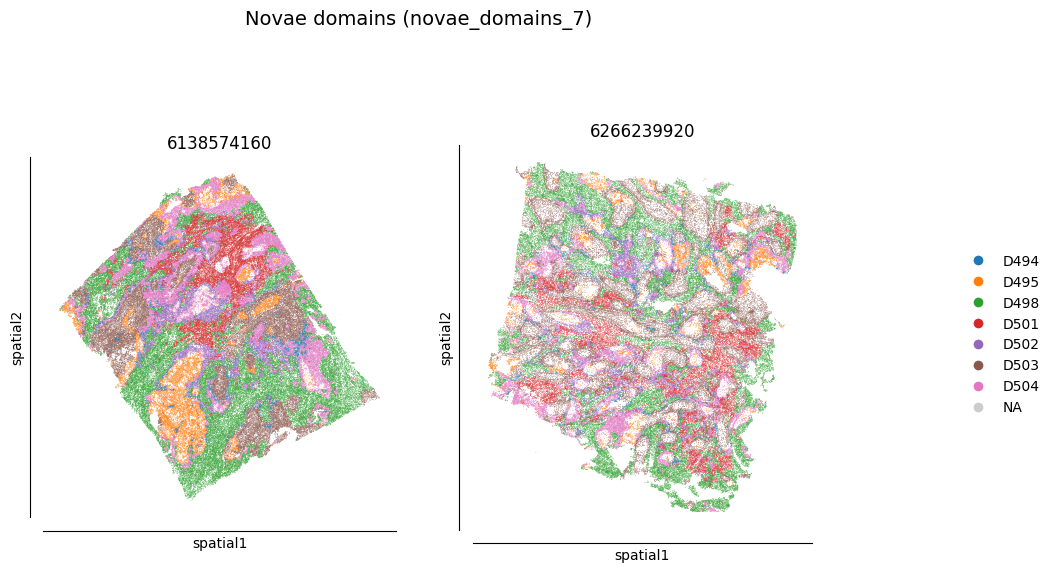

In [17]:
novae.plot.domains(adatas, cell_size=100)